In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("data_modified.csv")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Dependents,Year_Customer,TotalMnt,TotalPurchases,TotalCampaignsAcc
0,1826,1970,Graduation,Divorced,84835.0,0,0,0,189,104,...,0,0,1,0,SP,0,2014,1190,15,1
1,1,1961,Graduation,Single,57091.0,0,0,0,464,5,...,0,1,1,0,CA,0,2014,577,18,2
2,10476,1958,Graduation,Married,67267.0,0,1,0,134,11,...,0,0,0,0,US,1,2014,251,11,0
3,1386,1967,Graduation,Together,32474.0,1,1,0,10,0,...,0,0,0,0,AUS,2,2014,11,4,0
4,5371,1989,Graduation,Single,21474.0,1,0,0,6,16,...,0,0,1,0,SP,1,2014,91,8,2


# STATISTICAL ANALYSIS

## 1. What factors are significantly related to the number of store purchases?

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
import shap

### One Hot Encoding

In [4]:
df2 = df.drop(["ID"], axis=1)

In [5]:
cat = df2.select_dtypes(exclude=np.number)

In [6]:
enc = OneHotEncoder(sparse_output=False, dtype=np.int8)

In [7]:
result = pd.DataFrame(enc.fit_transform(cat))
result.columns = enc.get_feature_names_out()

In [8]:
df3 = pd.concat([result, df2.drop(cat.columns, axis=1)], axis=1)

### Train test split

In [9]:
X = df3.drop(["NumStorePurchases"], axis=1)
y = df3[["NumStorePurchases"]]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

### Linear Regression

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [12]:
preds = model.predict(X_test)

In [13]:
print(f"Linear Regression model RMSE: {np.sqrt(mean_squared_error(y_test, preds))}")

Linear Regression model RMSE: 2.588274203447844e-14


In [14]:
perm = permutation_importance(model, X_train, y_train)

In [15]:
pd.DataFrame(
    {
        "feature": X_train.columns.tolist(),
        "weight": perm.importances_mean
    }
).nlargest(4, "weight")

,feature,weight
46,TotalPurchases,11.023039
34,NumCatalogPurchases,1.518283
33,NumWebPurchases,1.475166
32,NumDealsPurchases,0.721450


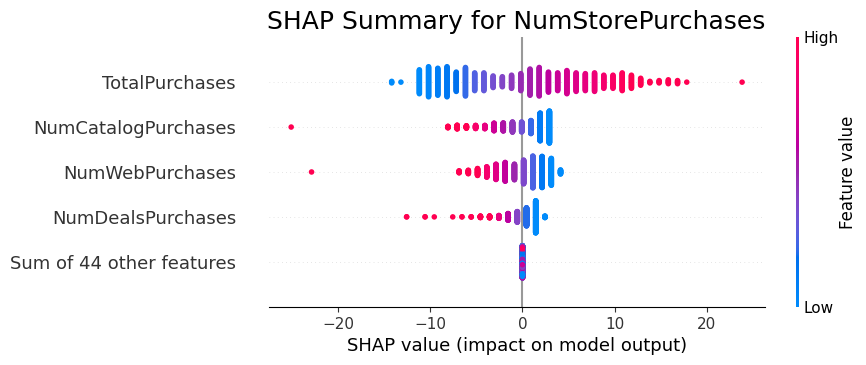

In [16]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

plt.title("SHAP Summary for NumStorePurchases", size=18)
shap.plots.beeswarm(shap_values, max_display=5)

As we can see, the following factors are related to the number of store purchases:
- TotalPurchases
- NumCatalogPurchases
- NumWebPurchases
- NumDealsPurchases

## 2. Does US fare significantly better than the Rest of the World in terms of total purchases?

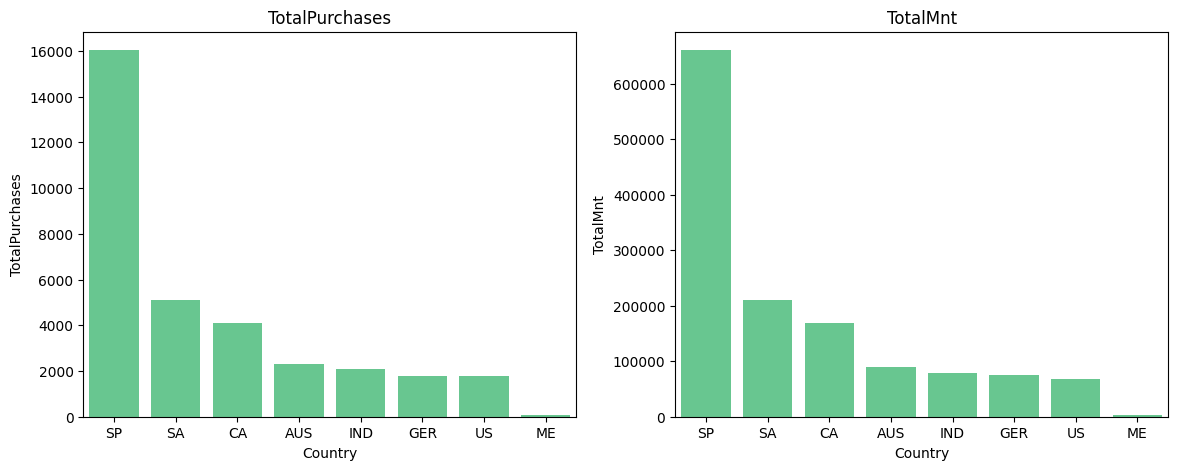

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for i, col in enumerate(("TotalPurchases", "TotalMnt")):
    sns.barplot(df.groupby("Country")[col].sum().sort_values(ascending=False), ax=ax[i], color="#58D68D")
    ax[i].set_title(col)

plt.show()

Findings
- Spain has the highest number of purchases
- US is second to last in terms of total amount and purchases, therefore, it does not fare better than the rest of the world


## 3. People who have spent an above average amount on gold in the last two years have more in store purchases. Justify or refute this statement

Let's plot the relationship between MntGoldProds and NumStorePurchases

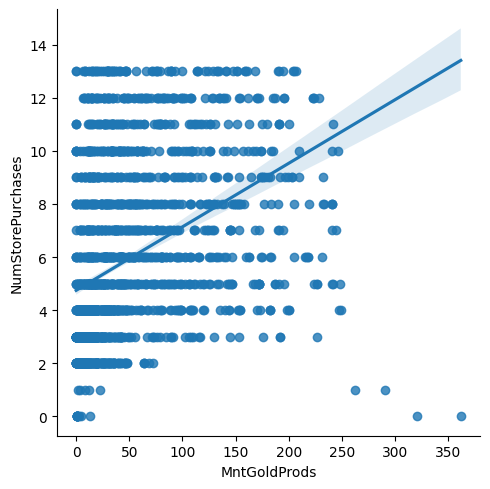

In [18]:
sns.lmplot(df, x="MntGoldProds", y="NumStorePurchases")
plt.show()

These two features seem to be related positively. However, is it statistically significant?\
To confirm or deny this theory, we will conduct two tests: Kendall correlation and t-test\
For that, we should also set the p-value threshold p = 0.05

### Kendal correlation

In [19]:
from scipy.stats import kendalltau

In [20]:
kendall_corr = kendalltau(x=df["MntGoldProds"], y=df["NumStorePurchases"])

In [21]:
print(f"Kendall correlation: {kendall_corr.correlation}")
print(f"Kendall p-value: {kendall_corr.pvalue}")

Kendall correlation: 0.39259824522472614
Kendall p-value: 4.9775414379777585e-152


### t-test

In [22]:
from scipy import stats

In [23]:
temp = df[["MntGoldProds", "NumStorePurchases"]]

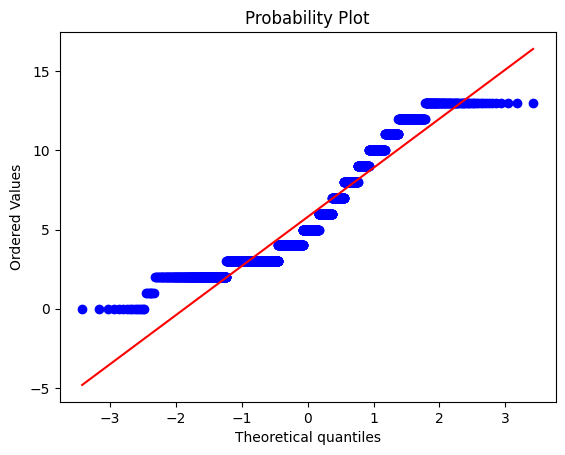

In [24]:
fig, ax = plt.subplots()
stats.probplot(temp["NumStorePurchases"], dist="norm", plot=ax)
plt.show()

Since our NumStorePurchases values are NOT distributed normally, we can use the Central Limit Theorem (CTL)\
to be able to apply t-test to our data

In [25]:
avg = temp["MntGoldProds"].mean()
below = temp[temp["MntGoldProds"] < avg]
above = temp[temp["MntGoldProds"] >= avg]

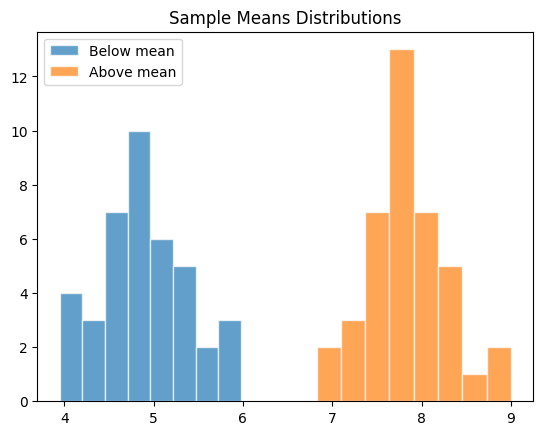

In [26]:
fig, ax = plt.subplots()

below_means = []
above_means = []

for data, means, label in zip([below, above], [below_means, above_means], ["Below mean", "Above mean"]):
    for _ in range(40):
        mean = np.mean(np.random.choice(data["NumStorePurchases"], size=40))
        means.append(mean)
    ax.hist(means, bins=8, alpha=.7, edgecolor="white", label=label)

ax.set_title("Sample Means Distributions")
plt.legend()
plt.show()

Check the result for normality using Shapiro-Wilk test

In [27]:
print(f"p-value for values below mean: {stats.shapiro(below_means).pvalue}")
print(f"p-value for values above mean: {stats.shapiro(above_means).pvalue}")

p-value for values below mean: 0.6802579598799179
p-value for values above mean: 0.41567958333129607


Perform t-test on the samples

In [28]:
ttest = stats.ttest_ind(below_means, above_means)

In [29]:
print(f"p-value: {ttest.pvalue}")
print(f"below threshold: {ttest.pvalue < 0.05}")

p-value: 1.1146598215475604e-42
below threshold: True


Conclusion: there is indeed a significant relationship between the amount spend on Gold products and the number of store purchases

## 4. Fish has Omega 3 fatty acids which are good for the brain. Accordingly, do "Married PhD candidates" have a significant relation with amount spent on fish?

In [30]:
temp = pd.DataFrame(
    {
        "is_married_phd": ((df["Marital_Status"] == "Married") & (df["Education"] == "PhD")).astype(np.int8),
        "MntFishProducts": df["MntFishProducts"]
    }
)

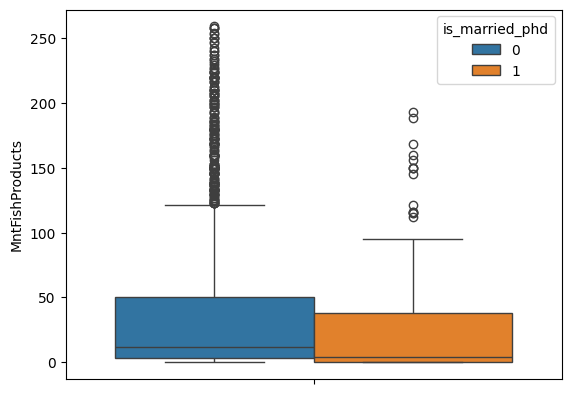

In [31]:
sns.boxplot(temp, y="MntFishProducts", hue="is_married_phd")
plt.show()

In [32]:
print(f"Kendall correlation p-value: {stats.kendalltau(x=temp["is_married_phd"], y=temp["MntFishProducts"]).pvalue}")

Kendall correlation p-value: 2.8343988294653555e-05


Findinds: Married PhD people spend less money on fish products than the rest of the clients

## 5. What other factors are significantly related to amount spent on fish?

We will build a linear regression model to determine the factors that are related to amount spent on fish

### Linear Regression

In [33]:
X = df3.drop(["MntFishProducts"], axis=1)
y = df3[["MntFishProducts"]]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [35]:
model2 = LinearRegression().fit(X_train, y_train)
preds = model2.predict(X_test)

In [36]:
print(f"Linear Regression RMSE {np.sqrt(mean_squared_error(y_test, preds))}")

Linear Regression RMSE 5.555090208346023e-13


### Permutation Importance

In [37]:
perm = permutation_importance(model2, X_train, y_train, random_state=1)

In [38]:
pd.DataFrame(
    {
        "feature": X_train.columns.tolist(),
        "weight": perm.importances_mean
    }
).nlargest(5, "weight")

,feature,weight
45,TotalMnt,253.530903
26,MntWines,81.002444
28,MntMeatProducts,34.704479
30,MntGoldProds,1.887200
29,MntSweetProducts,1.177779


### SHAP values

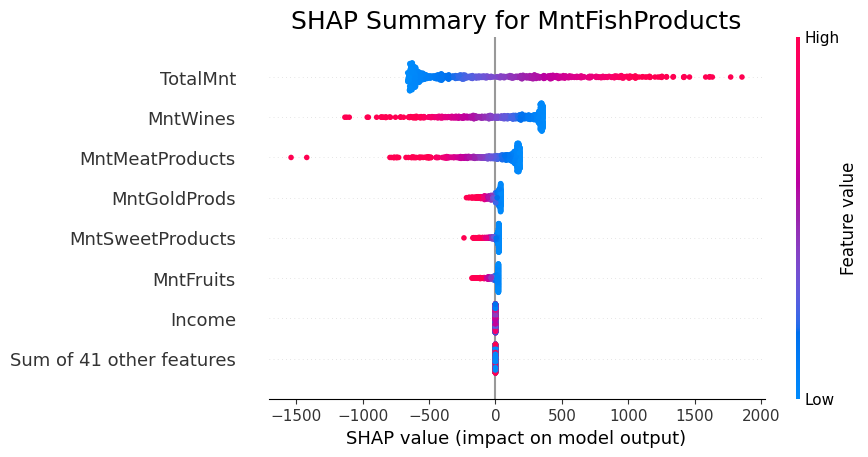

In [39]:
explainer = shap.Explainer(model2, X_train)
shap_values = explainer(X_test)

plt.title("SHAP Summary for MntFishProducts", size=18)
shap.plots.beeswarm(shap_values, max_display=8)

Conclusion: TotalMnt, MntWines, MntMeatProducts, MntGoldProducts, MntSweetProducts are significantly related to the amount spent on fish products\
MntFishProducts increases as TotalMnt increases\
The other features negatively impact MntFishProducts

## 6. Is there a significant relationship between geographical region and success of a campaign?

In [40]:
temp = pd.melt(
    frame=df,
    id_vars="Country",
    value_vars=[col for col in df.columns if col.startswith("AcceptedCmp") or col == "Response"],
    var_name="Campaign",
    value_name="Accepted (%)"
)
df_camp = pd.DataFrame(temp.groupby(["Country", "Campaign"])["Accepted (%)"].mean() * 100).reset_index(drop=False)

df_camp["Campaign"].replace(
    {
        "AcceptedCmp1": "1",
        "AcceptedCmp2": "2",
        "AcceptedCmp3": "3",
        "AcceptedCmp4": "4",
        "AcceptedCmp5": "5",
        "Response": "most recent"
    },
    inplace=True
)

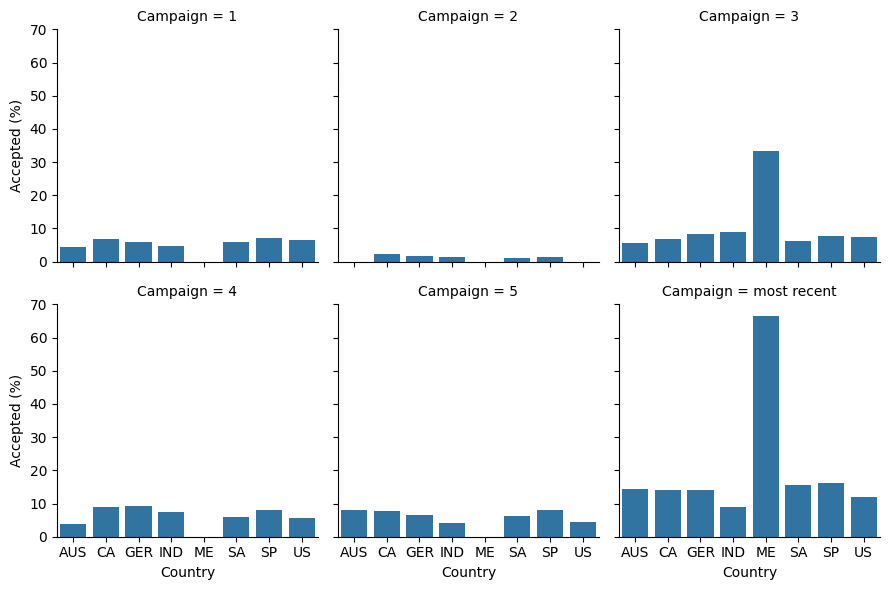

In [45]:
g = sns.FacetGrid(df_camp, col='Campaign', col_wrap=3)
g.map(sns.barplot, 'Country', 'Accepted (%)')
plt.show()

Findings:
- campaign acceptance rates are low overall
- the campaign with the highest acceptance rates is the most recent campaign
- the country with the highest campaign acceptance rate in the 3rd and last campaign is Mexico